# Using EM Algorithm for Customer Segmentation


## Problem

Suppose we collected data on all items purchased by our customers during a fixed time period.

For each item, we have its **category**, **price**, and **shopper id**. We could display these data in the following pivot table:
```
 Purchases (Grouped by Shopper and by Category)
+==============================================================+
| Shopper ID | Category1 | Category2 | Category 3 | Cetegory 4 |
+============+===========+===========+============+============+
| 1          | $39.95    |           | $15.45     |            |
|            | $31.05    |           | $14.06     |            |
|            | $28.49    |           |            |            |
|            | $58.98    |           |            |            |
|            |           |           |            |            |
| 2          | $15.49    | $109.34   | $16.95     | $98.50     |
|            |           | $156.00   | $16.95     |            |
|            |           |  $99.12   |            |            |
|            |           | $109.34   |            |            |
| 3          | $19.99    |           |            | $74.50     |
|            | $39.99    |           |            | $81.95     |
|            | $19.99    |           |            |            |
|            | $21.50    |           |            |            |
|            | $29.75    |           |            |            |
|    ...     |    ...    |    ...    |     ...    |     ...    |
+============+===========+===========+============+============+
```

Our goal is to **find segments in our customer base**, so that customers from the same segment have similar purchasing behaviour (similar purchase counts and amounts per category), while customers from different segments have different purchasing behaviour.

We can quantify customer $i$'s "preference" for category $k$ by looking at the **expected purchase frequency (count)** $\lambda_{i,k}$ made by the customer in that category. In fact, in our analysis "category" could be not only a shopping category, but also a specific product or a specific store or a specific period or day of the week. 

(Basically, we can apply these techniques to any "event" data that can be aggregated by some type of categorical feature into a count dataset: pageviews per article, phone calls per day of the week, etc.) 

Suppose that there are $S$ "hidden" (unobserved) customer segments, so that for any customer $i$ the following holds:

$$\text{Customer }i\text{ belongs to segment }s \;\;\;\implies\;\;
\lambda_{i,k} = \lambda_{sk}\text{ (segment }s\text{ expected purchase count in category }k\text{)}$$

So we need to figure out the number of hidden segments, find segment means (counts and amounts), and finally classify each customer into one of the segments. Then we will be able to make **predictions** and develop **targeted campaigns** for each segment.

## Model

The goal is to fit our data with the following Bayesian Network (or "Finite Mixture Model"):

$$
\begin{cases}
S \text{ segments}\\
K \text{ categories}\\
N \text{ observations}
\end{cases}
\implies
\begin{cases}
P(Z_n=z)=\pi_z, & Z_n\text{ is the unobserved (latent) segment of customer }n\\ 
P(Y_{nk}=y_{nk}\;|\;Z_n=z) = p(y_n; \lambda_{zk}),& Y_{nk}\text{ is the observed count in category }k\text{ for customer } n
\end{cases}
$$

Above, $p(y_{nk};\lambda_{zk})$ can be any distribution describing count data and parametrized by unknown parameters $\lambda_{nk}$. 

Examples: Poisson distribution, Zero-inflated Poisson distribution, Negative-Binomial distribution.

The system has unknown parameters $\pi_z$ and $\lambda_{zk}$ which can be estimated from the observed data using __Expectation Maximization (EM)__ technique.

Also, because EM is essentially a Maximum Likelihood-based approach, we can make ad-hoc comparisons of likelihood gains for different numbers $S$ of hidden segments (will be demonstrated below). So the approach lets us find hidden clusters, _interpret_ them by estimating segment-specific properties ($\lambda_{zk}$'s) and also _select the "best" number of these clusters_.

## My Implementation of EM in Python

I decided to write a generic EM algorithm in Python that would allow estimating a variety of models that have latent variables. (Basically, the end goal is to be able to estimate any Bayesian Network).

This is work-in-progress: https://github.com/kulmatitskiy/corrcount-python/tree/master/emalg

__In this Notebook I will demonstrate a few use cases.__



#### Prepare workspace...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import logging
import pandas as pd
%pylab inline
logging.getLogger().setLevel(logging.ERROR)

Populating the interactive namespace from numpy and matplotlib


## Confirm that Algorithm works for Gaussian Mixtures
Let's test my code with Gaussian Mixtires because they are the most widely used learning examples for Expectation-Maximization algorithm.

### Old Faithful data set

This is __the__ set used in the article about Expectation Maximization!  (https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm)

This data set is a popular example because there are two clearly distinct segments with different Multivariate Gaussian parameters.

In [3]:
from emalg.network import Network
from emalg.segment import SegmentComponent
from emalg.gaussian import GaussianMixtureComponent

faithful = pd.read_csv('example_data/faithful.csv')
network = Network([SegmentComponent, GaussianMixtureComponent], data=faithful, num_segments=2)
network.run()

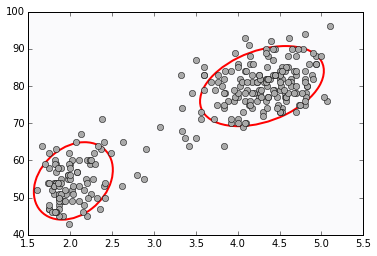

In [4]:
faithful_fitted_fig = network.fitted_component_plots(1)

It works! Now let's try some artificial data.

### Synthetic data

In [22]:
from numpy import random
num_segments = 5

# generate random data with random centers and covariance matrices
samples = list()
for s in range(num_segments):
    means = 25 * random.ranf(size=2)
    R = random.rand(2, 2)
    cov = np.dot(R, R.transpose())*10
    samples.append(random.multivariate_normal(means, cov, size=random.randint(40,80)))
synth_data = pd.DataFrame(np.vstack(samples))

# see what the dat looks like
synth_data.head()

,0,1
0,3.187590,4.118505
1,-0.540089,0.006234
2,1.331049,2.098032
3,4.686287,8.119096
4,4.889236,6.878233


In [23]:
# use EM
network = Network([SegmentComponent, GaussianMixtureComponent], data=synth_data, num_segments=num_segments)
network.run()

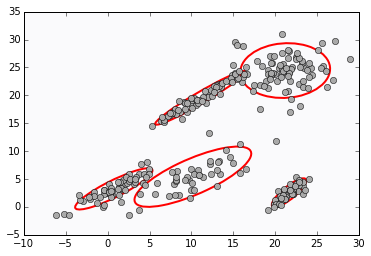

In [24]:
network.fitted_component_plots(1)

It works!

__Now let's move on to count data.__

## Use EM with Poisson Mixture to Analyze Customer Purchases

### Example 1: Shoes and Clothes

In this data set each row represents some customer's purchase counts by category in a fixed period (say, a month).
The categories are __Clothes__ and __Shoes__.

$N=2226$ observations

In [3]:
counts1 = pd.read_csv('example_data/mens.csv')
counts1.head()

,Clothes,Shoes
0,2,0
1,1,3
2,20,2
3,7,0
4,3,0


In [4]:
counts1.describe()

,Clothes,Shoes
count,2226.000000,2226.000000
mean,4.311770,2.554807
std,8.210151,3.683660
min,0.000000,0.000000
25%,0.000000,0.000000
50%,2.000000,1.000000
75%,5.000000,3.000000
max,106.000000,43.000000


#### Step 0. Make imports

In [24]:
from emalg.poisson import PoissonComponentWithLatentClasses

#### Step 1. Choose Number of Segments by inspecting log-likelihoods

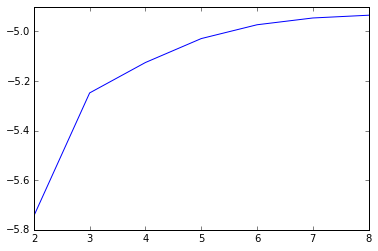

In [17]:
max_segments = 8
num_segments_range = range(2, max_segments + 1)
networks = list()
for num_segments in num_segments_range:
    network = Network([SegmentComponent, PoissonComponentWithLatentClasses], 
                      data=counts1, num_segments=num_segments, dealing_with_zero_probs='exclude')
    network.run(num_attempts=200)
    networks.append(network)

plt.plot(num_segments_range, np.array([net.e_ll_best for net in networks]))

_Notes_:

- `num_attempts` controls the number of times we run EM algorithm with a new random starting point. This is useful because __EM estimates depend on the starting point__, so we would like to try several starts
- This is called multi-start technique and it can be done in parallel (current implementation is sequential).
- The plot shows that the most significant gain results from increasign the number of segments from $S=2$ to $S=3$.
- Also, it looks like the gains flatten off after $S=6$.
- So let's make an ad-hoc decision to use $S=6$ segments.

#### Step 2. Choose S=6 and interpret parameter estimates

In [18]:
# Choose network with num_segments = 6
best_network = networks[4]

In [20]:
# Make Pandas Dataframe with estimates from both network components (Segments, Poisson)
pd.concat([best_network.fitted_component_info(0), best_network.fitted_component_info(1)], join='inner', axis=1)

,Probability,Size in sample,Exp Counts in Clothes,Exp Counts in Shoes
S01,0.01,20,63.7,21.4
S02,0.31,688,0.4,2.8
S03,0.05,102,22.2,6.3
S04,0.18,405,8.0,2.6
S05,0.04,100,4.1,10.8
S06,0.41,911,2.3,0.6


_Notes_:

- The model succeeeded in identifying the 1% segment (S01) with extreme number of purchases in both categories.
- Similarly, two other small segments (S03 with 5% of population and  S05 with 4% of population) have extreme counts, but each in its own category (S03 in Clothers, S05 in Shoes)
- Segments S02, S04, S06 are the "majority" segments:
  - S02 with focus on Shoes (2-3 purchases)
  - S06 with focus on Clothes (2-3 purchases)
  - S04 buys both Shoes and Clothes, but way more Clothes than Shoes (8 clothing purchases vs 2-3 shoes purchases)

#### Step 3. Assess Model Fit by Looking at Aggregate Metrics

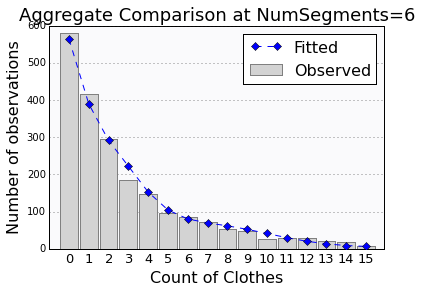

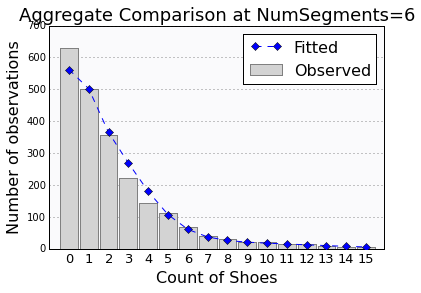

In [22]:
# extract fitted plots from Poisson component, which has index 1 in out network:
best_network.fitted_component_plots(1)

_Notes_:

- These plots focus on __marginal__ distribution of counts (i.e., probabilities based on all hidden segments):
$$\text{graph}(y) = N * P(Y_{nk}=y),\;\;y=0,1,2,\dots$$
- These plots compare theoretical distribution of counts per category (blue "fitted" curves) vs. the observed distribution of counts per category (gray bars)
- The model seems to work poorly at predicting $P(Y_{nk}=3)$ in both categories and also $P(Y_{nk}=4)$ in shoes. So, either the number of segments is too low, or the whole model does not fit the data very well and we should try something else instead of Poisson. 

### Example 2: Male/Female Shoes and Clothes

In this data set each row represents some customer's purchase counts by category in a fixed period (say, a month).
The categories are __Clothes__ and __Shoes__ __by gender__ (so 4 categories).

$N=5000$ observations

In [26]:
counts2 = pd.read_csv('example_data/ex1.csv')
counts2.head()

,WomensClothes,WomensShoes,MensClothes,MensShoes
0,15,2,0,0
1,4,4,0,0
2,0,0,2,0
3,10,2,0,0
4,1,2,0,0


In [27]:
counts2.describe()

,WomensClothes,WomensShoes,MensClothes,MensShoes
count,5000.00000,5000.000000,5000.000000,5000.000000
mean,6.39540,4.426000,1.919600,1.137400
std,12.35754,6.550626,5.881739,2.766234
min,0.00000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000
50%,2.00000,2.000000,0.000000,0.000000
75%,7.00000,6.000000,1.000000,1.000000
max,262.00000,92.000000,106.000000,43.000000


#### Step 1. Choose Number of Segments by inspecting log-likelihoods

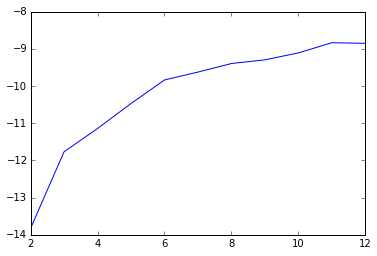

In [30]:
max_segments = 12
num_segments_range = range(2, max_segments + 1)
networks = list()
for num_segments in num_segments_range:
    network = Network([SegmentComponent, PoissonComponentWithLatentClasses], 
                      data=counts2, num_segments=num_segments, dealing_with_zero_probs='exclude')
    network.run()
    networks.append(network)

plt.plot(num_segments_range, np.array([net.e_ll_best for net in networks]))

#### Step 2. Choose S=8 and interpret parameter estimates

In [35]:
# Make Pandas Dataframe with estimates from both network components (Segments, Poisson)
pd.concat([best_network.fitted_component_info(0), best_network.fitted_component_info(1)], join='inner', axis=1)

,Probability,Size in sample,Exp Counts in WomensClothes,Exp Counts in WomensShoes,Exp Counts in MensClothes,Exp Counts in MensShoes
S01,0.19,941,0.3,0.4,2.9,2.8
S02,0.03,133,56.4,19.2,7.5,2.2
S03,0.09,435,21.3,7.2,0.6,0.1
S04,0.04,211,11.2,8.2,9.2,4.0
S05,0.29,1452,6.3,1.7,0.3,0.1
S06,0.27,1345,1.0,4.2,0.1,0.2
S07,0.07,356,4.2,16.8,0.3,1.2
S08,0.03,126,0.5,0.5,22.9,8.0


#### Step 3. Assess Model Fit by Looking at Aggregate Metrics

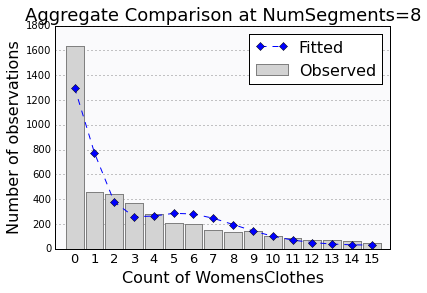

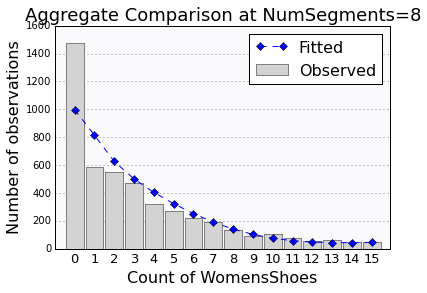

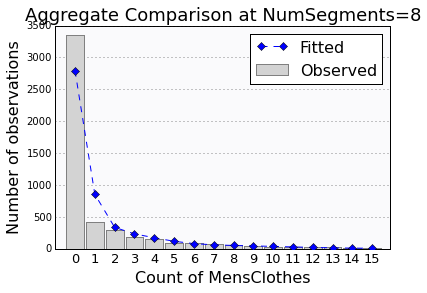

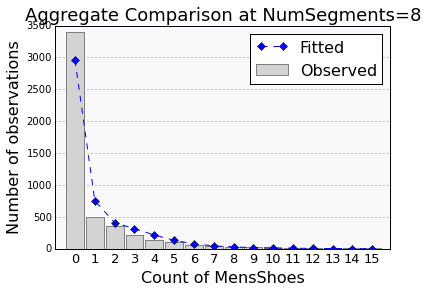

In [34]:
# extract fitted plots from Poisson component, which has index 1 in out network:
best_network.fitted_component_plots(1)